# Crypto Price Prediction

In this project, I will be predicting apple stock price using pandas and scikit learn module(RandomForestClassifier). I'll be downloading the apple stock price data from Yahoo Finance, I will also do some analysis and show some plots on the downloaded data. I will create a model which will predict the prices of the apple stock and then finally i will create a backtesting engine with the data.

The reason for this project: Since this project is associated with real life data, my goal is to be able to help real time traders predict if they should buy crypto or not. We'd want to know if the price is going to increase tomorrow so we can buy or if the price will drop so we don't do anything.

## Method

-  We'll be downloading the apple stock price data from Yfinance which has the stock symbol 'AAPL'.
-  Then we'll explore the dataset 
-  Then we'll be setting the dataset to predict future prices using historical prices
-  We'll also test a machine learning model
-  Setup a backtesting engine
-  Improve the accuracy of the model


In [88]:
#importing the relevant libraries

import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

In [89]:
#Downloading the apple stock data

aapl = yf.Ticker("AAPL")
aapl_hist = aapl.history(period="max")
aapl_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12,0.099722,0.100155,0.099722,0.099722,469033600,0.0,0.0
1980-12-15,0.094953,0.094953,0.094519,0.094519,175884800,0.0,0.0
1980-12-16,0.088015,0.088015,0.087582,0.087582,105728000,0.0,0.0
1980-12-17,0.089749,0.090183,0.089749,0.089749,86441600,0.0,0.0
1980-12-18,0.092351,0.092785,0.092351,0.092351,73449600,0.0,0.0


## Data Exploration

### Feature description

From exploring the aapl_hist data, we can see that it's a dataframe containing columns and rows of daily numbers of the Apple stock. Here are the details of the columns shown above:
-  Date: date of observation
-  Open: The opening price
-  High: Highest price
-  Low: Lowest price
-  Close: The closing price
-  Adj Close: The closing price after adjustments for splits and dividend
-  Volume: Total stocks traded <br> 

The row index of the DataFrame is the date the stock was traded. Stock doesn't trade every day (there is no trading on weekends and holidays), so some dates are missing. 

### Checking for missing values

In [90]:
aapl_hist.isnull().any()

Open            False
High            False
Low             False
Close           False
Volume          False
Dividends       False
Stock Splits    False
dtype: bool

As we can see there is no missing values in the dataset, so we'll prepare the data for the machine learning model

### Plotting the 'Close' column

<AxesSubplot:xlabel='Date'>

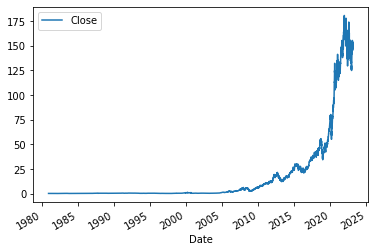

In [91]:
aapl_hist.plot.line(y = "Close", use_index = True)

We see that the closing price was hightest between 2020 and the present date.

In [92]:
corr = aapl_hist.corr()
corr.style.background_gradient(cmap='coolwarm')

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Open,1.000000,0.999938,0.999925,0.999841,-0.220496,0.097956,0.011547
High,0.999938,1.000000,0.999913,0.999926,-0.220006,0.097456,0.011784
Low,0.999925,0.999913,1.000000,0.999928,-0.221260,0.097812,0.011538
Close,0.999841,0.999926,0.999928,1.000000,-0.220643,0.097738,0.011764
Volume,-0.220496,-0.220006,-0.221260,-0.220643,1.000000,-0.032202,0.001417
Dividends,0.097956,0.097456,0.097812,0.097738,-0.032202,1.000000,-0.001160
Stock Splits,0.011547,0.011784,0.011538,0.011764,0.001417,-0.001160,1.000000


There is high correlation between Open, High, Low and Close

## Data Preparation

Remember that we mentioned something about predicting the future prices of the apple stock, now the first step in doing that is to first identify the target in which we are trying to predict. Our target will be 0 if the price goes down and 1 if the price goes up.<br><br>Next, we'll shift the data from previous days "forward" one day, so we can use it to predict the target price. This ensures that we don't accidentally use data from the same day to make predictions! (a very common mistake)

Then, we'll combine both so we have our training data.

### Creating the Target

We do this by first copying the Close column to a new DataFrame called data and renaming it to actual_close. This ensures that we can continue to see the value that the stock actually closed at on each day. (we'll be shifting things around later, so it's important to preserve this).

Then, we setup our target by doing the following:

- Using the pandas rolling method across every 2 rows of the DataFrame. This will first look at ('1980-12-12', '1986-12-15'), then ('1980-12-15', '1980-12-16'), and so on across the DataFrame.
- We will compare the second row to the first row to see if it is greater. If it is, return 1, otherwise 0.
- We then just look at the Close column.<br>

As you can see above, the Target column now indicates if the price went up or down on the given day. If Target is 1, the price went up. If Target is 0, the price went down.

This is what we want our machine learning model to predict!

In [93]:
# Copying the close pice
data = aapl_hist[["Close"]]
data = data.rename(columns = {"Close": "Actual_Close"})

#Creating our target column
data["Target"] = aapl_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [94]:
data.head()

,Actual_Close,Target
Date,,
1980-12-12,0.099722,NaN
1980-12-15,0.094519,0.0
1980-12-16,0.087582,0.0
1980-12-17,0.089749,1.0
1980-12-18,0.092351,1.0


### Shifting the data forward

In this part, we'll be using the pandas dataframe __[shift](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html?highlight=shift#pandas.DataFrame.shift )__ method to move all rows forward by one trading day.<br><br>If this is not done, we'll be predicting tomorrow's price with tomorrow's information. E.g using 1980-12-12 to predict the target of 1980-12-12 and this will give us a great output when testing the model but when applied to real life we'll find that we'll do so poorly.

In [95]:
#shifting the data one row forward
aapl_prev = aapl_hist.copy()
aapl_prev = aapl_prev.shift(1)

In [96]:
aapl_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-15,0.099722,0.100155,0.099722,0.099722,469033600.0,0.0,0.0
1980-12-16,0.094953,0.094953,0.094519,0.094519,175884800.0,0.0,0.0
1980-12-17,0.088015,0.088015,0.087582,0.087582,105728000.0,0.0,0.0
1980-12-18,0.089749,0.090183,0.089749,0.089749,86441600.0,0.0,0.0


### Combining our data

Next, we'll combine out Target column with the columns we want to use to make predictions. We'll use the pandas __[join](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html?highlight=join#pandas.DataFrame.join)__ method to join our DataFrames.<br><br> After we join our data, we see that we'll be predicting the target using data from the previous day. The columns we'll use to predict our target are ["Close", "Volume", "Open", "High", "Low"].

In [97]:
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(aapl_prev[predictors]).iloc[1:]

In [98]:
data.head()

,Actual_Close,Target,Close,Volume,Open,High,Low
Date,,,,,,,
1980-12-15,0.094519,0.0,0.099722,469033600.0,0.099722,0.100155,0.099722
1980-12-16,0.087582,0.0,0.094519,175884800.0,0.094953,0.094953,0.094519
1980-12-17,0.089749,1.0,0.087582,105728000.0,0.088015,0.088015,0.087582
1980-12-18,0.092351,1.0,0.089749,86441600.0,0.089749,0.090183,0.089749
1980-12-19,0.097987,1.0,0.092351,73449600.0,0.092351,0.092785,0.092351


## Machine Learning Model

Next, we'll create a machine learning model to see how accurately we can predict the stock price.

Since we're dealing with time series data, we won't use cross-validation to create predictions for the whole dataset. This will cause leakage where data from the future will be used to predict past prices. This doesn't match with the real world, and will make us think that our algorithm is much better than it actually is.

So we'll be splitting our data sequentially, we'll start off by predicting just the last 100 rows using the other rows.

We'll use a random forest classifier to generate our predictions.

### Model Setup 

Since we're using a __[RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)__ model, the first thing we'll do is to import the model from scikit-learn. If you do not have scikit-learn you can install it on your environment with !pip install scikit-learn. 

We're trying to get a 0 or 1 target, hence it is a classification problem. We can also use logistic regression to solve this problem too. 

When we initialize the model, we pass in a few parameters:

- n_estimators - this is the number of individual decision trees that the algorithm should create. A random forest is an ensemble of decision trees that is more robust to overfitting than an individual tree. The more trees, the more robust the algorithm, but fewer trees means it runs faster.
- min_samples_split - this is minimum number of samples any decision tree should split on. The lower this is, the more prone the trees are to overfitting. Setting it higher also makes it run faster.
- random_state - this is nice to set so that running the algorithm twice over the same data returns the same results.

In [99]:
#!pip install scikit-learn
#skip the above step if you have scikit-learn

from sklearn.ensemble import RandomForestClassifier
import numpy as np

#creating the model
model = RandomForestClassifier(n_estimators = 100, min_samples_split = 200, random_state = 1)

### Training the Model

Once we've setup the model, we can train it on the last 100 rows of the dataset. We're using all of the data except the last 100 rows to predict the last 100 rows. When you're working with time series data, it's important to never use future data to predict the past.

The fit method will train the model using our predictors to predict the Target.

In [100]:
#splitting the model into train data and test data
train = data.iloc[:-100]
test = data.iloc[-100:]

#fitting the model
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

### Measuring Error

We'll be measuring the accuracy of the model using a precision score. We'll do this using a precision score function in scikit-learn. By doing this, we get a percentage of how many times our model predicted correctly that a price will go up and it eventually did. This will help us minimize our risk.

Here are the steps we'll follow;
- import the scikit-learn precision_score function
- Generate predictions from our model using the predict function. This will give us a 0 or a 1 for each row.
- The predict method returns a numpy array. To make it easier to work with, we'll turn it into a pandas Series.
- Finally, we execute the precision_score function, passing in the predictions and the target.

In [101]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5571428571428572

Our model has an accuracy of 56% at the moment. We can take a deeper look at the individual predictions and the actuals, and see where we're off. And how we can make it better.

We can do this by plotting the target against the predictions. We do this by first combining the Target column and Predictions column into one DataFrame using the concat function. This function joins two pandas objects. In this case, each object is a series, so we want to join them on axis=1, so each one becomes a column.

Then, we can plot the DataFrame to visualize both columns.


<AxesSubplot:xlabel='Date'>

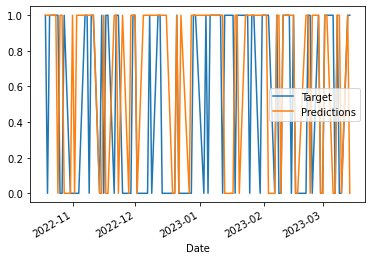

In [102]:
combined = pd.concat({"Target":test["Target"], "Predictions": preds}, axis = 1)
combined.plot()

we can see that some days the predictions were off while some days it was on point

## Creating a Backtesting Engine

From all we have done so far you can tell that our model is not great, but here's the good news; it can be improved. Now all we have to do is to figure out a way to predict on the whole dataset and not just the last 100 days. This is where the backtesting engine comes in. 

I know we all have questions as to what a backtesting engine is and what is it function. With Backtesting Engine, you can test your trading strategy with historical data and see how it would have worked in various market scenarios. It's a safeguard against what could happen if you make a mistake in live trading so that when you do go live, you have a greater chance of success. Meaning we can use more days in the dataset to make predictions

Our backtesting method will loop over the dataset, and train a model every 800 rows. We'll make it a function so we can avoid rewriting the code if we want to backtest again. Ideally, we'd train a model more often than every 800 rows, but for speed purposes we will set the number high.

Before we write our full backtesting loop, let's write the code for a single iteration. In the below code:

- We'll take the first 1000 rows of the data as our training set
- We'll take the next 800 rows as our testing set
- We'll fit our machine learning model to the training set
- We'll make predictions on the test set

This is similar to what we did before, but we changed which rows we're looking at.

In [103]:
#Creating the backtest engine with a backtest function

def backtest(data, model, predictors, start=1000, step=800):
    predictions = []
    
    #loop through increment in the dataset
    for i in range(start, data.shape[0], step):
        #split data into train and test
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        #fit the model
        model.fit(train[predictors],train["Target"])
        
        #Make the predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index = test.index)
        preds[preds > .6] = 1
        preds[preds <= .6] = 0
        
        #combining the datsets
        combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis = 1)
        
        predictions.append(combined)
        
    return pd.concat(predictions)

In the above code, we created a loop and wrapped it in a function, to make it easier to work with. A function means we can easily call it later. The function will take the data, the machine learning model, and the predictors as inputs. We'll also set start and step as optional parameters.

In the backtesting function, we;

- Split the training and test data
- Train a model
- Make predictions on the test data using predict_proba(we use the predict_proba method to get the probabilities of the price going up, not just 0s and 1s)
- Combine our predictions with the actual Target, so we can calculate error easily
- Return all of the predictions

This function will enable us to create predictions across our whole dataset whenever we want.

### Running the Function

Now that we have created the backtest engine, we can call it anywhere in the notebook to generate our predictions across the whole dataset

In [104]:
predictions = backtest(data, model, predictors)

In [105]:
predictions

,Target,Predictions
Date,,
1984-11-27,1.0,0.0
1984-11-28,1.0,0.0
1984-11-29,0.0,0.0
1984-11-30,0.0,0.0
1984-12-03,0.0,0.0
...,...,...
2023-03-08,1.0,0.0
2023-03-09,0.0,0.0
2023-03-10,0.0,0.0


In [106]:
predictions["Predictions"].value_counts()

0.0    8833
1.0     818
Name: Predictions, dtype: int64

In [107]:
predictions["Target"].value_counts()

1.0    4841
0.0    4810
Name: Target, dtype: int64

In [108]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5122249388753056

As you can see from the codes above, we got the value_counts and the precisions_core. And the value_counts tell us how many days we predicted that the price will go up, and as we can see it predicted that it will go up 817 days, and that is because we set the threshold to .6 . If we were to lower the threshold, we would get more days the price will go up but the precision will be low.

Also if you see the precison score we got, you'll see it's actually low. We would add more predictors to the model to increase the accuracy.

## Improving Accuracy of the Model

You can see that our model wasn't accurate from the above codes, but the good news is we can make predictions across the full dataset. Now what we can do is to add more predictors to improve the accuracy.

We'll add in some rolling means, so the model can evaluate the current price against recent prices. We'll also look at the ratios between different indicators.

### Rolling Means

Rolling means helps the algorithm evaluate the current price against the average price this week, quarter, or year. For example, if the price now is higher than the annual price, it could mean that the stock is on an upward trend or vise versa. Rolling averages are useful for finding long-term trends otherwise disguised by occasional fluctuations.

We will use the pandas __[rolling](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html)__ method to calculate the rolling mean of the Close column for different time horizons.

In [109]:
weekly_mean = data.rolling(7).mean()["Close"]
bi_weekly_mean = data.rolling(14).mean()["Close"]
monthly_mean = data.rolling(30).mean()["Close"]
quarterly_mean = data.rolling(90).mean()["Close"]
annual_mean = data.rolling(365).mean()["Close"]


We can also tell the algorithm how many days in the last week the price has gone up. We can do this by using the pandas shift and rolling methods:

- We'll shift the data forward, so we're not incorporating information from the current day into our predictor. If we don't use shift, then the algorithm would have knowledge of the actual target and that would not make our algorithm good with real world data.
- Find the 7-day rolling sum of the target. If the price went up for all 7 days, this would be 7. If it went up 0 days, this would be 0.

In [110]:
weekly_trend = data.shift(1).rolling(7).mean()["Target"]

Now we will add our ratios

In [111]:
data["weekly_mean"] = weekly_mean / data["Close"]
data["bi_weekly_mean"] = bi_weekly_mean / data["Close"]
data["monthly_mean"] = monthly_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]

Next, we'll add in the ratios between different rolling means. This helps the algorithm understand what the weekly trend is relative to the annual trend.

In [112]:
data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_bi_weekly_mean"] = data["annual_mean"] / data["bi_weekly_mean"]
data["annual_monthly_mean"] = data["annual_mean"] / data["monthly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]

Next, we'll add our weekly trend into the predictor DataFrame.

In [113]:
data["weekly_trend"] = weekly_trend

Then, we'll add some ratios between intraday open, low, and high prices and the close price. This helps the algorithm understand what the price trend was during the last day. For example, if the high was much higher than the close price, it may mean that the stock was on a downward trend at the end of the day.

In [114]:
data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

Now we'll update our predictors list with our new predictors.

In [115]:
new_predictors = predictors + ["weekly_mean", "bi_weekly_mean", "monthly_mean", "quarterly_mean", "annual_mean",
                              "annual_weekly_mean", "annual_bi_weekly_mean", "annual_monthly_mean", 
                               "annual_quarterly_mean", "weekly_trend"]

### Updating the Predictors

We can now update our predictions with our new predictors. We have remove the first 365 rows because our rolling means will have NaN values for the first 365 rows. We want to make sure we have consistent data for every row that we make predictions for.

In [116]:
predictions = backtest(data.iloc[365:], model, new_predictors)

In [117]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5096618357487923

Our model has a precision of 0.5—in other words, when it predicts a tumor is malignant, it is correct 50% of the time

### Prediction Evaluation

Now, we can check to see how many trades we would have made. We can again do this with value_counts.


In [118]:
predictions["Predictions"].value_counts()

0.0    8872
1.0     414
Name: Predictions, dtype: int64

As you can see, we would have made 414 trades using this algorithm. We'd have had a close to 60% chance that the price went up when our algorithm thought it would. This is a decent start, but there are a lot of next steps we can take to improve the algorithm further!

<AxesSubplot:xlabel='Date'>

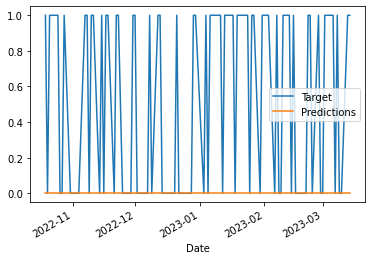

In [119]:
# Look at trades we would have made in the last 100 days

predictions.iloc[-100:].plot()

It did not predict any upward trend 